# 1. Load Data
------

In [3]:
!pip install kagglehub[pandas-datasets]
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn

In [4]:
import kagglehub
import os
# Store the path of the Kaggle dataset
path = kagglehub.dataset_download("jonassouza872/vitoria-da-conquista-weather-data-september")
# Check if the path is correct
print(path)

# List all files inside the downloaded folder
print(os.listdir(path))

Using Colab cache for faster access to the 'vitoria-da-conquista-weather-data-september' dataset.
/kaggle/input/vitoria-da-conquista-weather-data-september
['temp.csv']


In [5]:
import pandas as pd
df = pd.read_csv(f"{path}/temp.csv")  # Reads the declared path as a CSV file
df.head()  # Prints the first 5 rows of the dataset

,Timestamp,Temp_MPU6050_C,Temp_AHT20_C,Umid_AHT20_pct,Temp_BMP280_C,Press_BMP280_hPa,Temp_BMP180_C,Press_BMP180_hPa,Temp_DS18B20_C,Temp_NTC_C,Temp_DHT11_C,Umid_DHT11_pct
0,2025-08-31 22:31:02,20.86,19.90,73.37,21.28,921.24,20.19,923.02,25.69,22.26,20.03,66.0
1,2025-08-31 22:31:33,21.75,19.97,75.57,21.48,921.12,20.27,923.04,23.81,20.73,20.02,66.0
2,2025-08-31 22:32:05,21.80,19.75,74.31,21.25,921.20,20.16,923.06,22.50,20.88,20.02,67.0
3,2025-08-31 22:32:36,21.57,19.55,74.77,21.07,921.15,20.06,922.99,21.31,20.62,20.01,66.0
4,2025-08-31 22:33:07,21.66,19.60,75.09,21.12,921.25,20.06,923.02,21.88,20.95,20.00,66.0


In [6]:
df.columns #all columns

Index(['Timestamp', 'Temp_MPU6050_C', 'Temp_AHT20_C', 'Umid_AHT20_pct',
       'Temp_BMP280_C', 'Press_BMP280_hPa', 'Temp_BMP180_C',
       'Press_BMP180_hPa', 'Temp_DS18B20_C', 'Temp_NTC_C', 'Temp_DHT11_C',
       'Umid_DHT11_pct'],
      dtype='object')

# 2. Frequency analysis using the Fast Fourier Transform (FFT)

-------

The Fast Fourier Transform (FFT) is a computationally efficient algorithm that converts signals from the time domain to the frequency domain, decomposing them into a sum of sinusoids with different frequencies, amplitudes, and phases. Based on Fourier's theorem, FFT enables identification of periodic components and hidden cyclic patterns in time series that are difficult to detect visually in raw data. The technique is fundamental in digital signal processing, reducing computational complexity from O(n²) of conventional DFT to O(n log n), making analysis of large data volumes feasible. The magnitude of each spectral component reveals the oscillation intensity at that specific frequency, while the Nyquist frequency (half the sampling rate) defines the maximum detectable limit. FFT is widely applied in telecommunications, acoustics, image processing, vibration analysis, and any field requiring understanding of signal spectral behavior.

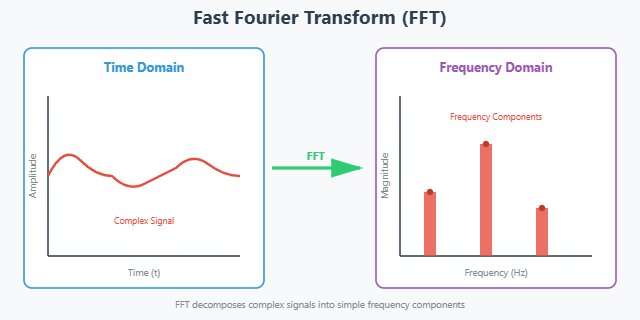

## 2.1. Temperature

----

Sampling Frequency: 0.033333 Hz
Nyquist Frequency: 0.016667 Hz


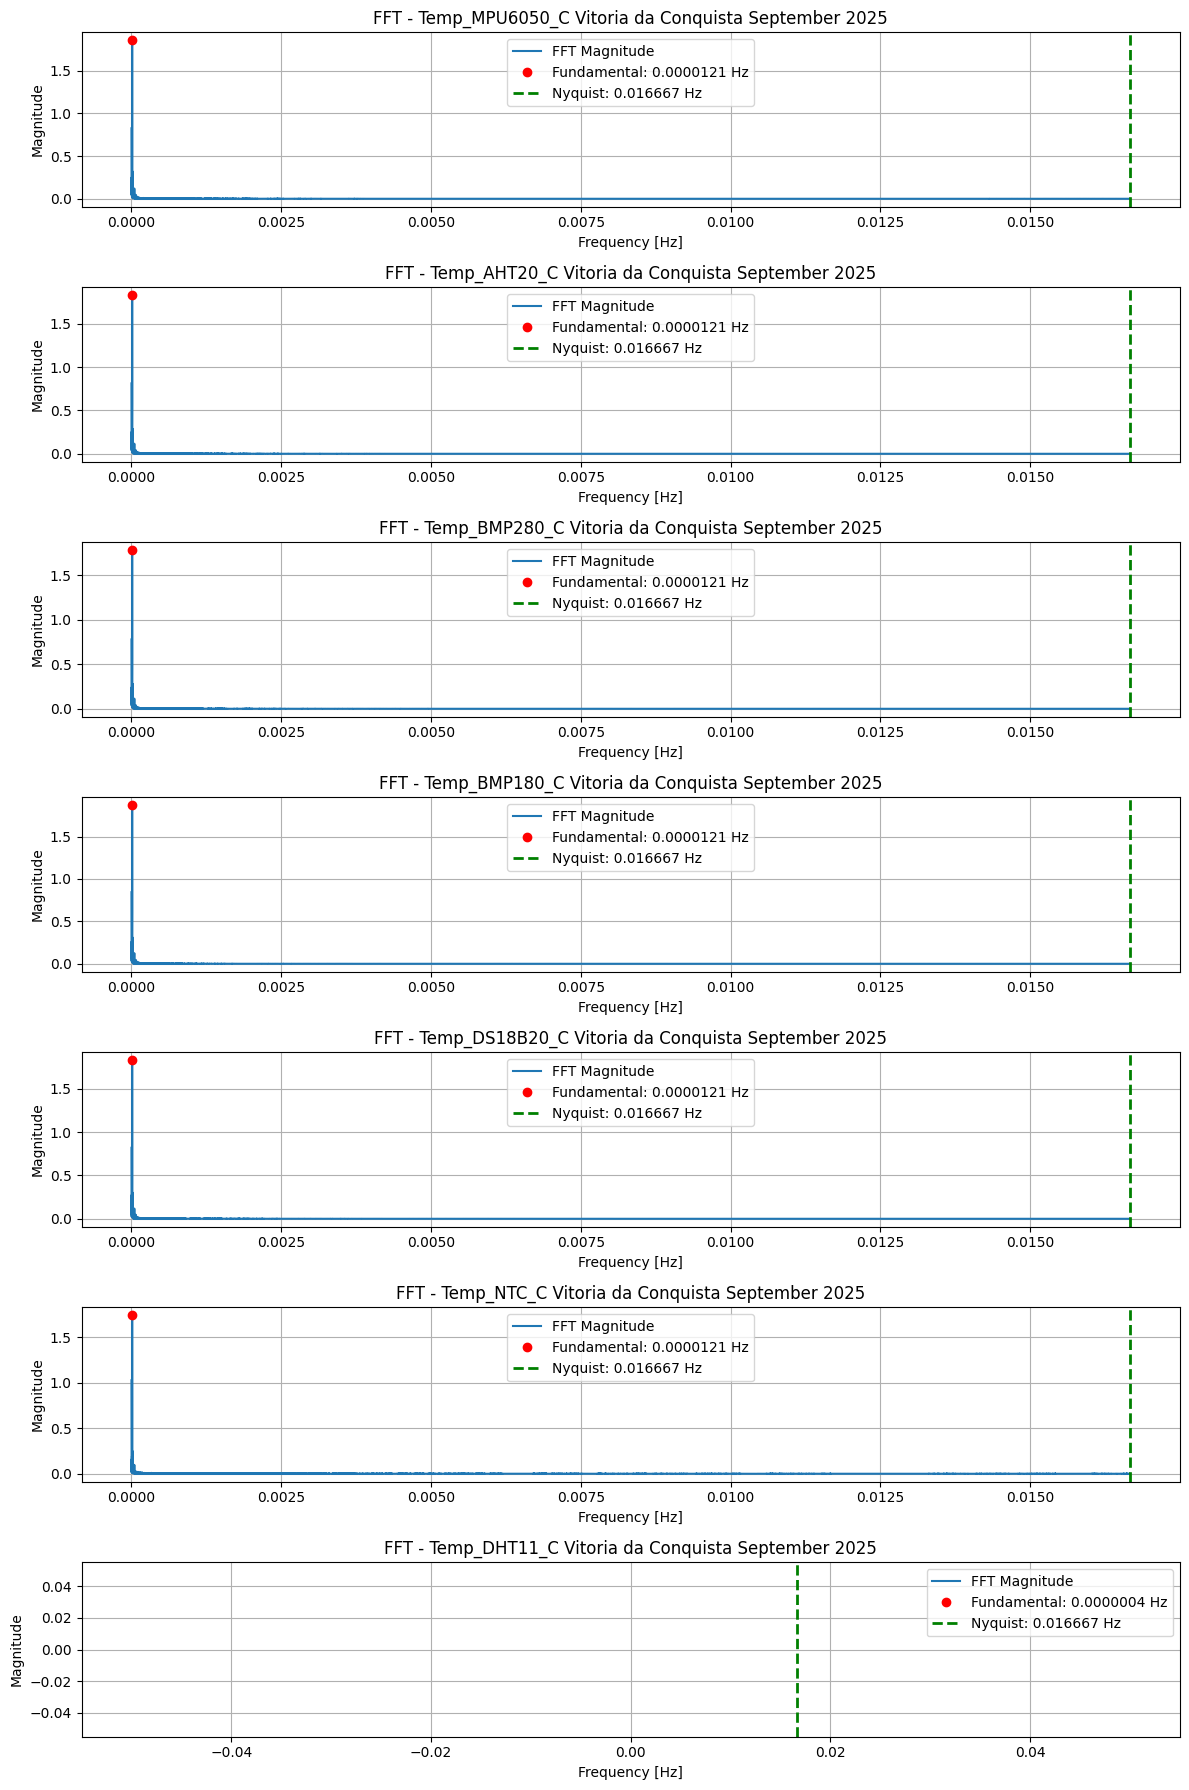

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

temp_sensors = ['Temp_MPU6050_C', 'Temp_AHT20_C', 'Temp_BMP280_C',
                'Temp_BMP180_C', 'Temp_DS18B20_C', 'Temp_NTC_C', 'Temp_DHT11_C']#all temperature sensors
timestep = 30  # adjust for the sampling interval in seconds

# Calculate Nyquist frequency
sampling_freq = 1 / timestep  #sampling frequency in Hz
nyquist_freq = sampling_freq / 2  #Nyquist frequency

print(f"Sampling Frequency: {sampling_freq:.6f} Hz")
print(f"Nyquist Frequency: {nyquist_freq:.6f} Hz")
plt.figure(figsize=(12, 18)) #plot figure size

for i, sensor in enumerate(temp_sensors): #for each temperature sensor
    y = df[sensor].values #stores all sensor values
    n = len(y) #gets the size of each sensor
    yf = np.fft.fft(y) #applies the fast fourier transform to the temperature values of each sensor
    xf = np.fft.fftfreq(n, d=timestep) #calculates the frequencies corresponding to each bin (position) of the FFT result.
    idx = np.arange(1, n//2) #only integer numbers
    xf_pos = xf[idx] #only positive values
    yf_pos = np.abs(yf[idx]) / n

    #Fundamental frequency
    fund_idx = np.argmax(yf_pos) #Finds the index of the maximum value of the array
    fund_freq = xf_pos[fund_idx] #finds the frequency corresponding to the maximum index
    fund_mag = yf_pos[fund_idx]# finds the maximum magnitude of this index

    # Plot
    plt.subplot(len(temp_sensors), 1, i+1)
    plt.plot(xf_pos, yf_pos, label='FFT Magnitude')
    plt.plot(fund_freq, fund_mag, 'ro', label=f'Fundamental: {fund_freq:.7f} Hz')
    plt.axvline(x=nyquist_freq, color='green', linestyle='--', linewidth=2, label=f'Nyquist: {nyquist_freq:.6f} Hz')
    plt.title(f'FFT - {sensor} Vitoria da Conquista September 2025')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

The FFT analysis of temperature sensors revealed a dominant frequency of 0.0000121 Hz (period of aprox 23 hours) across six sensors (MPU6050, AHT20, BMP280, BMP180, DS18B20, and NTC), clearly indicating the circadian cycle of day/night thermal variation. The magnitude of ~1.8 corresponds to a peak-to-peak variation of approximately 7°C, consistent with natural thermal oscillations in Vitória da Conquista during September. The DHT11 sensor showed a discrepant frequency (0.0000004 Hz) and very low magnitude ( aprox 0.04), evidencing its inadequacy for spectral analysis due to its limited 1°C resolution. The results validate the consistency and sensitivity of the other sensors in capturing environmental thermal patterns.

#2.2 Humidity

----

Sampling Frequency: 0.033333 Hz
Nyquist Frequency: 0.016667 Hz


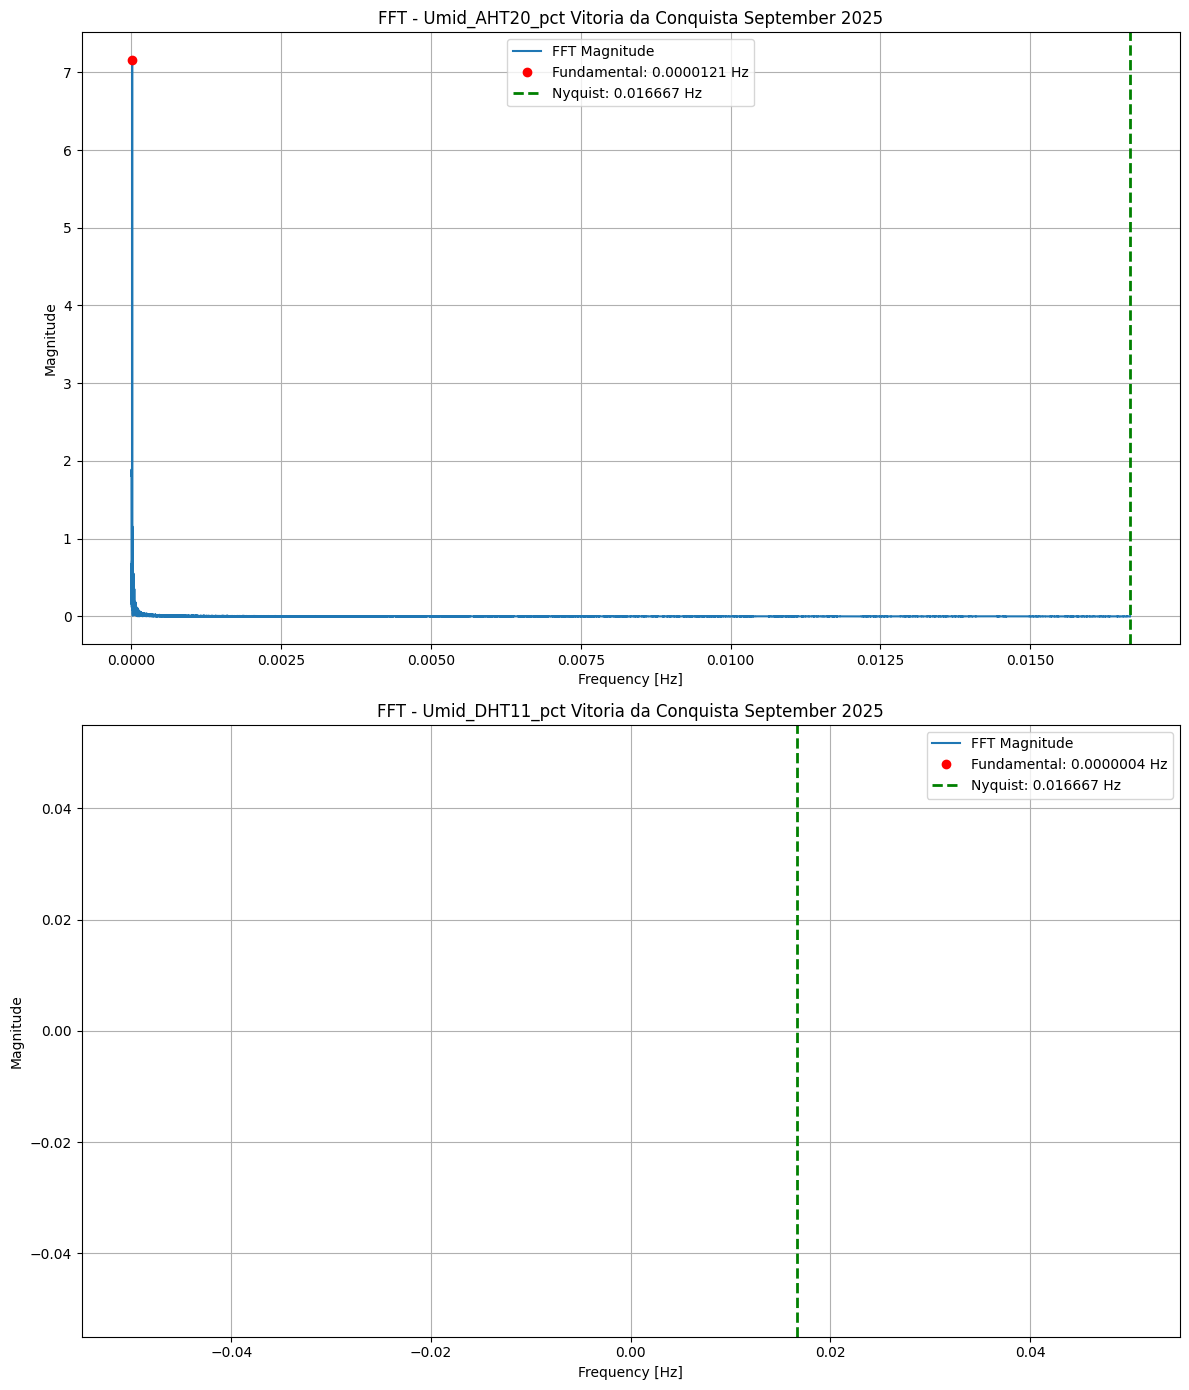

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

humidity_sensors = ['Umid_AHT20_pct','Umid_DHT11_pct']#all humidity sensors
timestep = 30  # adjust for the sampling interval in seconds

# Calculate Nyquist frequency
sampling_freq = 1 / timestep  #sampling frequency in Hz
nyquist_freq = sampling_freq / 2  #Nyquist frequency

print(f"Sampling Frequency: {sampling_freq:.6f} Hz")
print(f"Nyquist Frequency: {nyquist_freq:.6f} Hz")
plt.figure(figsize=(12, 14)) #plot figure size

for i, sensor in enumerate(humidity_sensors): #for each humidity sensor
    y = df[sensor].values #stores all sensor values
    n = len(y) #gets the size of each sensor
    yf = np.fft.fft(y) #applies the fast fourier transform to the humidity values of each sensor
    xf = np.fft.fftfreq(n, d=timestep) #calculates the frequencies corresponding to each bin (position) of the FFT result.
    idx = np.arange(1, n//2) #only integer numbers
    xf_pos = xf[idx] #only positive values
    yf_pos = np.abs(yf[idx]) / n

    #Fundamental frequency
    fund_idx = np.argmax(yf_pos) #Finds the index of the maximum value of the array
    fund_freq = xf_pos[fund_idx] #finds the frequency corresponding to the maximum index
    fund_mag = yf_pos[fund_idx]# finds the maximum magnitude of this index

    # Plot
    plt.subplot(len(humidity_sensors), 1, i+1)
    plt.plot(xf_pos, yf_pos, label='FFT Magnitude')
    plt.plot(fund_freq, fund_mag, 'ro', label=f'Fundamental: {fund_freq:.7f} Hz')
    plt.axvline(x=nyquist_freq, color='green', linestyle='--', linewidth=2, label=f'Nyquist: {nyquist_freq:.6f} Hz')
    plt.title(f'FFT - {sensor} Vitoria da Conquista September 2025')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

The FFT analysis of humidity sensors revealed behavior similar to temperature sensors, with the AHT20 showing a fundamental frequency of 0.0000121 Hz (~23 hours), confirming the circadian cycle of relative humidity variation throughout day/night. The magnitude of ~7.2 indicates significant humidity oscillations (approximately 28% peak-to-peak), reflecting ambient temperature changes that directly affect the air's capacity to retain water vapor. The DHT11 sensor again showed inadequate performance with a discrepant frequency (0.0000004 Hz) and near-zero magnitude, reinforcing its low resolution (1% RH) and insensitivity for refined spectral analysis. All detected fundamental values remained well below the Nyquist frequency (0.016667 Hz), validating the adequacy of the 30-second sampling rate for capturing slow environmental variations. The strong correlation between temperature and humidity spectral patterns demonstrates the expected physical coupling between these atmospheric quantities.

## 2.3. Pressure

-------------

Index(['Timestamp', 'Temp_MPU6050_C', 'Temp_AHT20_C', 'Umid_AHT20_pct',
       'Temp_BMP280_C', 'Press_BMP280_hPa', 'Temp_BMP180_C',
       'Press_BMP180_hPa', 'Temp_DS18B20_C', 'Temp_NTC_C', 'Temp_DHT11_C',
       'Umid_DHT11_pct'],

Sampling Frequency: 0.033333 Hz
Nyquist Frequency: 0.016667 Hz


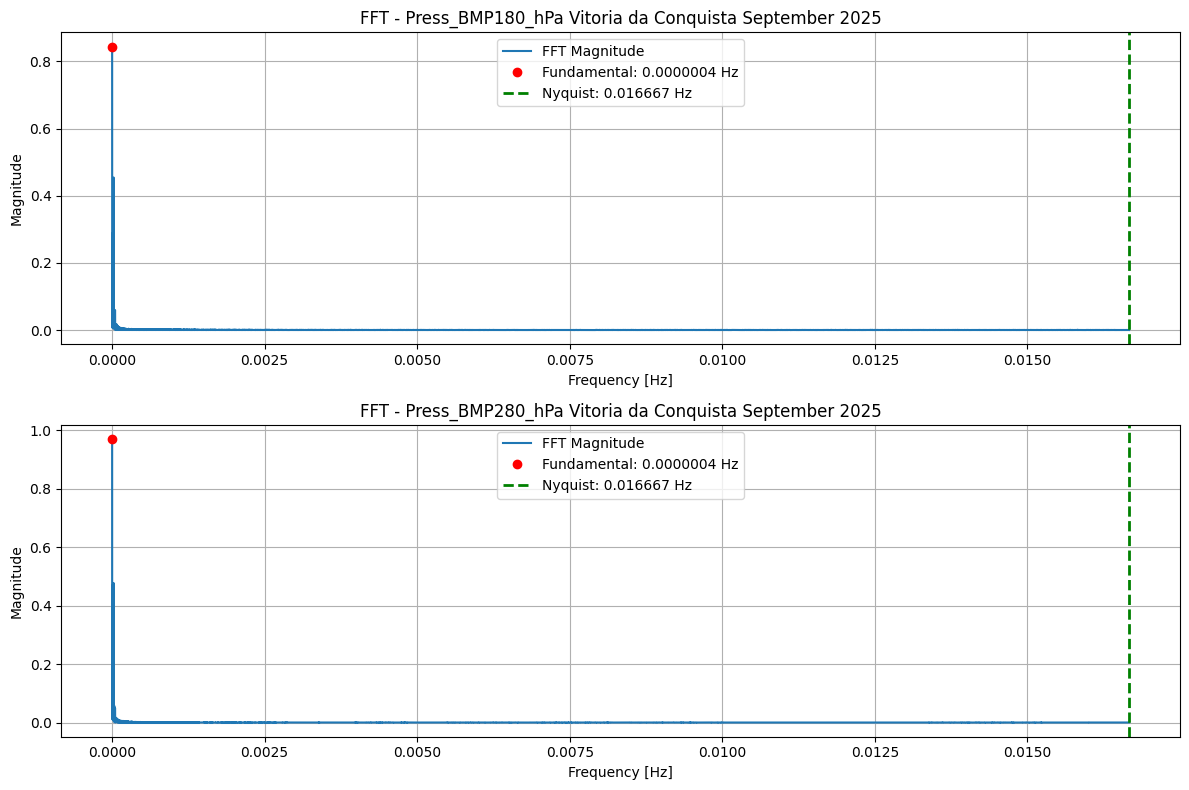

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pressure_sensors = ['Press_BMP180_hPa', 'Press_BMP280_hPa']#all pressure sensors
timestep = 30  # adjust for the sampling interval in seconds

# Calculate Nyquist frequency
sampling_freq = 1 / timestep  #sampling frequency in Hz
nyquist_freq = sampling_freq / 2  #Nyquist frequency

print(f"Sampling Frequency: {sampling_freq:.6f} Hz")
print(f"Nyquist Frequency: {nyquist_freq:.6f} Hz")
plt.figure(figsize=(12, 8)) #plot figure size

for i, sensor in enumerate(pressure_sensors): #for each pressure sensor
    y = df[sensor].values #stores all sensor values
    n = len(y) #gets the size of each sensor
    yf = np.fft.fft(y) #applies the fast fourier transform to the pressure values of each sensor
    xf = np.fft.fftfreq(n, d=timestep) #calculates the frequencies corresponding to each bin (position) of the FFT result.
    idx = np.arange(1, n//2) #only integer numbers
    xf_pos = xf[idx] #only positive values
    yf_pos = np.abs(yf[idx]) / n

    #Fundamental frequency
    fund_idx = np.argmax(yf_pos) #Finds the index of the maximum value of the array
    fund_freq = xf_pos[fund_idx] #finds the frequency corresponding to the maximum index
    fund_mag = yf_pos[fund_idx]# finds the maximum magnitude of this index

    # Plot
    plt.subplot(len(pressure_sensors), 1, i+1)
    plt.plot(xf_pos, yf_pos, label='FFT Magnitude')
    plt.plot(fund_freq, fund_mag, 'ro', label=f'Fundamental: {fund_freq:.7f} Hz')
    plt.axvline(x=nyquist_freq, color='green', linestyle='--', linewidth=2, label=f'Nyquist: {nyquist_freq:.6f} Hz')
    plt.title(f'FFT - {sensor} Vitoria da Conquista September 2025')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

The FFT analysis of atmospheric pressure sensors (BMP180 and BMP280) revealed an extremely low fundamental frequency of 0.0000004 Hz, corresponding to a period of approximately 29 days, indicating pressure variations associated with medium-term weather patterns rather than the daily circadian cycle. The reduced magnitudes (~0.85 and ~0.98) reflect pressure oscillations on the order of 3-4 hPa peak-to-peak, typical values for natural barometric variations caused by high and low-pressure systems moving through the region over weeks. Unlike temperature and humidity, which follow marked daily cycles, atmospheric pressure responds primarily to synoptic-scale phenomena (large-scale weather systems), explaining the absence of 23-hour periodicity in the data. Both BMP sensors showed perfect agreement on the detected fundamental frequency, validating the consistency of barometric measurements and the sensors' capability to capture long-term trends. The successful detection of this very low-frequency component demonstrates that the collection period (entire September) was sufficiently long to capture at least one complete cycle of significant meteorological variation.Tentar novamenteO Claude pode cometer erros. Confira sempre as respostas.

# 3. Conclusion

-------------------------